Scikit-learn pipelines to the rescue
-------------

Fortunately scikit-learn provides a set of helpful functions to deal with pipelines.
2 of them are the most important:

1. `sklearn.pipeline.make_pipeline`

    In our previous example we could define our transformer like this
    
```python
adder_normalizer = make_pipeline(
    AdderTransformer(add=10),
    MeanNormalizer()
)
```
Calling `fit` on the pipeline is the same as calling fit on each estimator in turn, transform the input and pass it on to the next step. The pipeline has all the methods that the last estimator in the pipeline has, i.e. if the last estimator is a classifier, the Pipeline can be used as a classifier. If the last estimator is a transformer, again, so is the pipeline.

2. `sklearn.pipeline.make_union`

    Creates a union of transformers
    
    ```
    
             transformer 1
           /               \
          /                 \
    input                     output
          \                 /    
           \               /
             transformer 2
             
    ```
             
    It is useful when the dataset consists of several types of data that one must 
    deal with separately.


Alternative way to define pipelines
--------------

```python
from sklearn.pipeline import Pipeline

adder_normalizer = Pipeline([
    ('adder', AdderTransformer(add=10)),
    ('normalizer', MeanNormalizer()),    
])

print(adder_normalizer)

>> Pipeline(steps=[('adder', <__main__.AdderTransformer object at 0x7f9387473750>), ('normalizer', <__main__.MeanNormalizer object at 0x7f9387137e50>)])
```



## Example: Predicting Absenteeism at Work

In [1]:
import pandas as pd 
import numpy as np

data = pd.read_csv('data/data.csv', index_col=0)
print(data.dtypes)
print()
print('Summary Statistics for Target Variable: \n', data['Absenteeism time in hours'].describe())
# we have a mix of categorical, numeric, and string data.
data.head(10)

ID                                   int64
Reason for absence                  object
Month of absence                     int64
Day of the week                     object
Distance from Residence to Work      int64
Service time                         int64
Age                                  int64
Work load Average/day              float64
Hit target                           int64
Disciplinary failure                 int64
Education                           object
Number of Children                   int64
Social drinker                       int64
Social smoker                        int64
Pet                                  int64
Weight                               int64
Height                               int64
Body mass index                      int64
Absenteeism time in hours            int64
dtype: object

Summary Statistics for Target Variable: 
 count    749.000000
mean       8.080107
std       17.001698
min        0.000000
25%        2.000000
50%        3.000000
75%   

,ID,Reason for absence,Month of absence,Day of the week,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Number of Children,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,Patient follow-up,7,Tuesday,36,13,33,239.554,97,0,High school,2,1,0,1,90,172,30,4
1,36,No reason given,7,Tuesday,13,18,50,239.554,97,1,High school,1,1,0,0,98,178,31,0
2,3,Blood donation,7,Wednesday,51,18,38,239.554,97,0,High school,0,1,0,0,89,170,31,2
3,7,Diseases of the eye and adnexa,7,Thursday,5,14,39,239.554,97,0,High school,2,1,1,0,68,168,24,4
4,11,Blood donation,7,Thursday,36,13,33,239.554,97,0,High school,2,1,0,1,90,172,30,2
5,3,Blood donation,7,Friday,51,18,38,239.554,97,0,High school,0,1,0,0,89,170,31,2
6,10,Medical consultation,7,Friday,52,3,28,239.554,97,0,High school,1,1,0,4,80,172,27,8
7,20,Blood donation,7,Friday,50,11,36,239.554,97,0,High school,4,1,0,0,65,168,23,4
8,14,"Injury, poisoning, and certain other consequen...",7,Monday,12,14,34,239.554,97,0,High school,2,1,0,0,95,196,25,40
9,1,Medical consultation,7,Monday,11,14,37,239.554,97,0,Postgraduate,1,0,0,1,88,172,29,8


# Explore the data

In [2]:
# Checking that we don't have any null values
assert data.isnull().all().all() == False

# Check mean about of time employees are absent
mean_absenteeism_time = data['Absenteeism time in hours'].mean()
print("Mean hours absent: "+str(round(mean_absenteeism_time,3)))
print()

# what are top 5 reasons for employees being absent?
print(data['Reason for absence'].value_counts().sort_values(ascending=False).nlargest(5))

Mean hours absent: 8.08

Blood donation                                                  149
Dental Consultation                                             112
Physiotherapy                                                    69
Diseases of the muskuloskeletal system and connective tissue     58
No reason given                                                  43
Name: Reason for absence, dtype: int64


# Prepare the data

In [3]:
# define the target and features of our dataset 
# we're trying to predict the number of hours someone will be absent based on their data
target = data['Absenteeism time in hours']
features = data.drop('Absenteeism time in hours', axis=1)

# split the data into a test and train set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)

In [4]:
# we only want numeric data for our model
# we want to separate numeric columns from categorical ones, so that they can be one-hot or label encoded
# we also want to separate numeric variables that are discrete vs continuous, because we don't want to scale numeric values

# what are all the columns we have?
print(list(features.columns))

# by looking at the total number of reasons of absence we have, we realise that we should label-encode them rather than
# one hot encode them, to keep the dimensionality of our dataset low
# education however only has 4 unique values, so we could one-hot encode that, along with days of the week (5)
print(len(set(features['Reason for absence'])))
print(len(set(features['Education'])))

['ID', 'Reason for absence', 'Month of absence', 'Day of the week', 'Distance from Residence to Work', 'Service time', 'Age', 'Work load Average/day ', 'Hit target', 'Disciplinary failure', 'Education', 'Number of Children', 'Social drinker', 'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index']
28
4


In [5]:
# we choose columns that are 1) continuous numeric, 2) discrete numeric, 3) to be label encoded, 4) to be one-hot encoded

numeric_columns = ['Distance from Residence to Work',
                   'Service time',
                   'Work load Average/day ',
                   'Weight',
                   'Hit target',
                   'Height',
                   'Body mass index']

discrete_columns = ['ID',
                    'Age',
                    'Month of absence',
                    'Disciplinary failure',
                    'Number of Children',
                    'Social drinker', 
                    'Social smoker', 
                    'Pet']

label_encode_columns = ['Reason for absence']

one_hot_encode_columns = ['Education', 'Day of the week']

# Building the Pipeline Transformers

In [6]:
# to use pytests, we need to set the file name to be the same as what we're working in
import ipytest.magics
import pytest
__file__ = '4. Pipelines.ipynb' # set the file name (required)

# we begin by importing the parent estimators and transformers we want to inherit from, and other relevant pipeline classes
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import Imputer

### Define our own column selector transformer

In [7]:
# we're going to write a tranformer that selects the columns we want from our dataset
# to do this, we write a class, that inherits from scikit_learn's baseestimator and transformermixin
# our ColumnSelector will inherit the functions from Transformmixin, meaning we can call fit_transform() and do fitting and transforming in one go
# in order to do that, we need to ensure we have two functions called fit() and transform() in this class

class ColumnSelector(BaseEstimator,TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
        
    def fit(self,x,y=None):
        return self
    
    def transform(self,x,y=None):
        return x.loc[:,self.columns]

### Test that our column selector transformer is working

In [8]:
%%run_pytest 

# we apply our columnselector by specifying the columns we want to pull out in each go. this is just for test purposes
# we then test our columns by ensuring the data in each is as we'd expect

numeric_selector = ColumnSelector(numeric_columns)
numeric_df = numeric_selector.fit_transform(x_train)

label_encode_selector = ColumnSelector(label_encode_columns)
label_encode_df = label_encode_selector.fit_transform(x_train)

one_hot_encode_selector = ColumnSelector(one_hot_encode_columns)
one_hot_encode_df = one_hot_encode_selector.fit_transform(x_train)

discrete_selector = ColumnSelector(discrete_columns)
discrete_df = discrete_selector.fit_transform(x_train)

# now we want to test that our ColumnSelector has worked correctly
# we use pandas is_numeric_dtype function to see if a column is numeric datatype
# we then run this in pytest using magic and assert key words

from pandas.api.types import is_numeric_dtype

def test_ColumnSelector():
    # Here, showing a test case for both categoric and numeric datatypes.
    for column in numeric_df:
        assert is_numeric_dtype(numeric_df[column]) == True
    
    # the ones that end with encode_df need to be encoded, and so shouldn't have numeric values yet.
    assert is_numeric_dtype(label_encode_df) == False
    assert is_numeric_dtype(one_hot_encode_df) == False

================================== test session starts ===================================
platform darwin -- Python 3.6.4, pytest-3.8.2, py-1.5.2, pluggy-0.7.1
rootdir: /Users/garethjones/Documents/Data Science/Data Science Retreat/11. Pipelines - Rachel, inifile:
plugins: palladium-1.2.0
collected 1 item

1.3 Pipelines .py .                                                                [100%]

================================ 1 passed in 0.06 seconds ================================


### Build and test one-hot encoding transformer

In [9]:
%%run_pytest 
# if we want to do ordinal / label encoding, sklearn's built in LabelEncoder class doesn't work with pipelines!
# so we have to import from python's Category Encoders package
from category_encoders.one_hot import OneHotEncoder

# build the one-hot encoder for test purposes
onehot_encoder = OneHotEncoder()
one_hot_encoded_df = onehot_encoder.fit_transform(one_hot_encode_df.values)

# let's run some tests to see that our one-hot encoded dataset is OK
assert one_hot_encoded_df.shape[0] == one_hot_encode_df.shape[0] # check same number of rows
assert one_hot_encoded_df.dtypes.all() == 'int64' # check they're all numbers
assert ((one_hot_encoded_df.values ==0) | (one_hot_encoded_df.values ==1)).all() # check they're just 1s and 0s
assert len(set(one_hot_encoded_df)) == one_hot_encoded_df.shape[1] # check that the width after is same as number of unique values

================================== test session starts ===================================
platform darwin -- Python 3.6.4, pytest-3.8.2, py-1.5.2, pluggy-0.7.1
rootdir: /Users/garethjones/Documents/Data Science/Data Science Retreat/11. Pipelines - Rachel, inifile:
plugins: palladium-1.2.0
collected 1 item

1.3 Pipelines .py .                                                                [100%]

==================================== warnings summary ====================================
/Users/garethjones/anaconda3/lib/python3.6/site-packages/_pytest/assertion/rewrite.py:268: PytestWarning: Module already imported so cannot be rewritten: palladium
  self.config,

-- Docs: https://docs.pytest.org/en/latest/warnings.html
========================== 1 passed, 1 warnings in 0.05 seconds ==========================


### Build and test the label encoding transformers

In [10]:
%%run_pytest
from category_encoders.ordinal import OrdinalEncoder

# build the encoder transformer for test purposes
label_encoder = OrdinalEncoder()
label_encoded_df = label_encoder.fit_transform(label_encode_df.values)

# let's run some tests to see that our label encoded dataset is OK
assert label_encoded_df.shape[0] == label_encode_df.shape[0] # check the number of rows is the same before and after
assert label_encoded_df.values.dtype == 'int64' # check our values are all numbers

================================== test session starts ===================================
platform darwin -- Python 3.6.4, pytest-3.8.2, py-1.5.2, pluggy-0.7.1
rootdir: /Users/garethjones/Documents/Data Science/Data Science Retreat/11. Pipelines - Rachel, inifile:
plugins: palladium-1.2.0
collected 1 item

1.3 Pipelines .py .                                                                [100%]

==================================== warnings summary ====================================
/Users/garethjones/anaconda3/lib/python3.6/site-packages/_pytest/assertion/rewrite.py:268: PytestWarning: Module already imported so cannot be rewritten: palladium
  self.config,

-- Docs: https://docs.pytest.org/en/latest/warnings.html
========================== 1 passed, 1 warnings in 0.05 seconds ==========================


### Build and test the standard scaler transformer

In [11]:
%%run_pytest[clean]
# unsure how this test for the standard scaler transformer is working? where's numeric_df coming from??

from sklearn.preprocessing import StandardScaler

def test_standardscaler():
    scaler = StandardScaler()
    scaled_numeric = scaler.fit_transform(numeric_df)
    
    assert np.isclose(scaled_numeric.mean(), 0)
    assert np.isclose(scaled_numeric.std(), 1)

================================== test session starts ===================================
platform darwin -- Python 3.6.4, pytest-3.8.2, py-1.5.2, pluggy-0.7.1
rootdir: /Users/garethjones/Documents/Data Science/Data Science Retreat/11. Pipelines - Rachel, inifile:
plugins: palladium-1.2.0
collected 1 item

1.3 Pipelines .py .                                                                [100%]

==================================== warnings summary ====================================
/Users/garethjones/anaconda3/lib/python3.6/site-packages/_pytest/assertion/rewrite.py:268: PytestWarning: Module already imported so cannot be rewritten: palladium
  self.config,

-- Docs: https://docs.pytest.org/en/latest/warnings.html
========================== 1 passed, 1 warnings in 0.05 seconds ==========================


## Now, to Pipelines!
We've tested our transformers and are sure they are working. What we need to do now is string them together in a pipeline, and re-combine the features from the various datatypes.

Without a pipeline, we would have had to do this by merging all or our new features. 
This is difficult, since after scaling, the numeric features are a matrix. The binary and categoric features are still dataframes.
A pipeline, combined with another scikit-learn tool `make_union`, does all of this work for us.

# Build the pipeline

### Pre-processing data pipeline

In [12]:
# we need to build a pipeline to run all of our transformers!
# we want to split the columns into different types, and then apply encoding / scaling etc

from sklearn.pipeline import make_pipeline, make_union
all_columns = list(features.columns)

# make_pipeline() is the function to use to put our transformer objects together
processing_pipeline = make_pipeline(
    # If using make_union, then we HAVE to first select all the columns we will pull from
    ColumnSelector(all_columns),
    make_union(
        # Select and don't do any further work to the discrete columns (they're already in the format we want)
        make_pipeline(ColumnSelector(discrete_columns),
        ),
        # Select numeric scalable columns, and scale using standardscaler transformer
        make_pipeline(
            ColumnSelector(numeric_columns),
            StandardScaler()
        ),
        # Select label-encoding columns and encode them accordingly
        make_pipeline(
            ColumnSelector(label_encode_columns),
            OrdinalEncoder()
        ),
        
        # Select one-hot-encoding columns and encode them accordingly
        make_pipeline(
            ColumnSelector(one_hot_encode_columns),
            OneHotEncoder()
        )
    )
)

In [13]:
# we can now call fit_transfrom on the processing_pipeline we made to link the together and prep the data
processed = processing_pipeline.fit_transform(features)

### Test the pre-processing component of our pipline

In [14]:
%%run_pytest[clean]

def test_processingpipeline():
    # remember, this first pipeline only acts on the features, not the target.
    processed = processing_pipeline.fit_transform(features)
    
    # check for data leakage
    assert features.shape[0] == processed.shape[0]

================================== test session starts ===================================
platform darwin -- Python 3.6.4, pytest-3.8.2, py-1.5.2, pluggy-0.7.1
rootdir: /Users/garethjones/Documents/Data Science/Data Science Retreat/11. Pipelines - Rachel, inifile:
plugins: palladium-1.2.0
collected 1 item

1.3 Pipelines .py .                                                                [100%]

==================================== warnings summary ====================================
/Users/garethjones/anaconda3/lib/python3.6/site-packages/_pytest/assertion/rewrite.py:268: PytestWarning: Module already imported so cannot be rewritten: palladium
  self.config,

-- Docs: https://docs.pytest.org/en/latest/warnings.html
========================== 1 passed, 1 warnings in 0.08 seconds ==========================


### Add a final estimator to our pipeline

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
import matplotlib.pyplot as plt

In [16]:
# we're going to add a random forest regressor to estimate the data in our pipeline so far
finalpipeline = (make_pipeline(processing_pipeline, RandomForestRegressor(random_state=1, 
                                                                          n_jobs=-1, 
                                                                          n_estimators=100)))

# then we can go ahead and fit this pipline on our training data, and it will do the random forest predictions for us
finalpipeline.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('columnselector', ColumnSelector(columns=['ID', 'Reason for absence', 'Month of absence', 'Day of the week', 'Distance from Residence to Work', 'Service time', 'Age', 'Work load Average/day ', 'Hit target', 'Disciplinary failure', 'Education', '...stimators=100, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False))])

# Predictions Using Pipeline

In [17]:
# create a function that will predict on our pipeline and put them together in a dataframe

def compare_predictions(x, y, finalpipeline, mean_target_value):
    # generate predictions:
    # Note: finalpipeline must have already been fit.
    
    predictions = finalpipeline.predict(x)
    y = y.reset_index()
    y.drop('index', axis=1, inplace=True)
    
    # a "lazy prediction" is where we return the average value of the target for every prediction
    # this just creates a vector of the same shape as predictions, filled with the mean absenteeism
    lazy_predictions = np.full(predictions.shape, mean_absenteeism_time)
    
    # put target, randomforest predictions, and mean absenteeism into one dataframe
    final_predictions = pd.DataFrame(pd.concat([y, pd.Series(predictions), pd.Series(lazy_predictions)], axis=1))
    final_predictions.rename(columns={'Absenteeism time in hours': 'True values',
                                      0: 'Predicted values',
                                      1: 'Lazy Predicted values'}, inplace=True)
    
    # use sklearn metrics to compute the rmse, mae, and r2 errors of our predictions against target
    rmse_lazy = sqrt(mean_squared_error(y, lazy_predictions))
    mae_lazy = mean_absolute_error(y, lazy_predictions)
    r2_lazy = r2_score(y, lazy_predictions)
    
    rmse = sqrt(mean_squared_error(y, predictions))
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    
    # print the values
    print('RMSE Lazy Predictor', rmse_lazy)
    print('MAE Lazy Predictor', mae_lazy)
    print('R^2 Lazy Predictor', r2_lazy)
    print()
    print('RMSE', rmse)
    print('MAE', mae)
    print('R^2', r2)
    print()
    print('RMSE Improvement:', rmse_lazy - rmse)
    print('MAE Inprovement:', mae_lazy - mae)
    print('R^2 Improvement:', abs(r2_lazy - r2))
    
    #plot a figure of the predictions for each line in our dataset
    plt.figure(figsize=(20,10))

    plt.plot(final_predictions.index, final_predictions['True values'], c='red', label='True Values')
    # plot a second data series 'Short students' in blue using the last three elements of x and y 
    plt.plot(final_predictions.index, final_predictions['Predicted values'], c='blue', label='Predicted Values')
    plt.plot(final_predictions.index, final_predictions['Lazy Predicted values'], c='black', label='Lazy Predicted Values')
    plt.legend(loc='best')
    plt.show()
    return predictions

RMSE Lazy Predictor 17.39060687943786
MAE Lazy Predictor 7.584059770289155
R^2 Lazy Predictor -9.971503794914405e-05

RMSE 5.208231424487479
MAE 2.3849689694464318
R^2 0.9102996009571304

RMSE Improvement: 12.182375454950382
MAE Inprovement: 5.199090800842724
R^2 Improvement: 0.9103993159950795


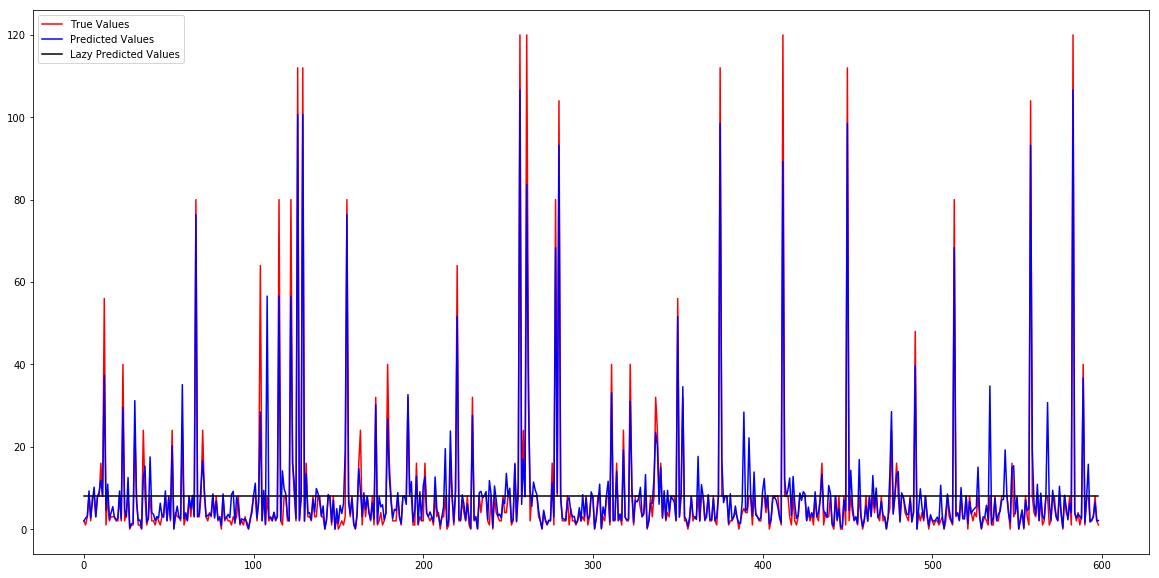

In [18]:
# call the compare predictions function to plot our results on training data
predictions_train = compare_predictions(x_train, y_train, finalpipeline, mean_absenteeism_time)

RMSE Lazy Predictor 15.287838787306207
MAE Lazy Predictor 6.864085447263014
R^2 Lazy Predictor -0.002061675079011893

RMSE 9.606258217063619
MAE 4.9845343915343925
R^2 0.6043503587020819

RMSE Improvement: 5.681580570242588
MAE Inprovement: 1.879551055728622
R^2 Improvement: 0.6064120337810938


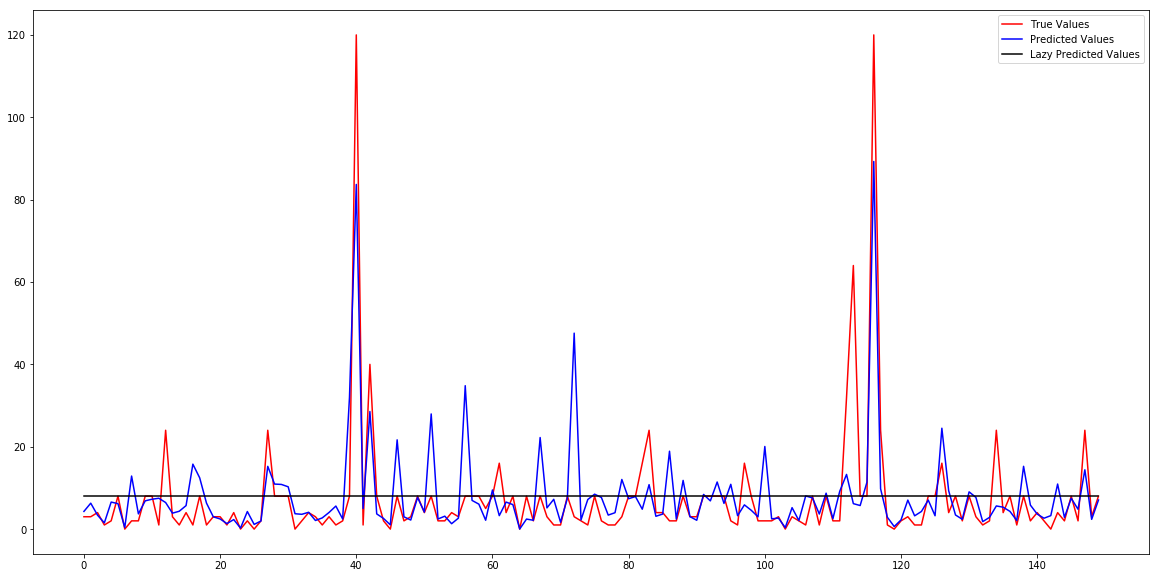

In [19]:
# call the compare predictions function to plot our results on test data
predictions_test = compare_predictions(x_test, y_test, finalpipeline, mean_absenteeism_time)

# Improve predictions with a grid search

Grid search
--------------------------

Scikit-learn has `GridSearchCV` and `RandomizedSearchCV`. Both have the same functionality and can be used to find optimal hyperparameters for sk-learn models. What is great about both these classes that they are both transformers - *they return an estimator so you can chain them and put in your pipeline*!

**GridSearchCV** - you specify the exact values of the parameters you want to test. <br>
**RandomizedSearchCV** - you specify ranges of parameters

In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.

Exercise
----------------------

1. Use `GridSearchCV` or `RandomizedSearchCV` to find the best parameters for the models. Check at least 2 parameters.

2. Inspect the attribute `cv_results_` after fitting. It gives a nice representation of the learning.

In [23]:
# set the parameters that we want to adjust and create into a grid

# Number of trees in random forest
n_estimators = [100, 500, 1000] 
# Number of features to consider at every split
max_features = [5, 10, 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 4)]
max_depth.append(None)

# Create the random grid
random_grid = {'randomforestregressor__n_estimators': n_estimators,
               'randomforestregressor__max_features': max_features,
               'randomforestregressor__max_depth': max_depth}

print(random_grid)

{'randomforestregressor__n_estimators': [100, 500, 1000], 'randomforestregressor__max_features': [5, 10, 'sqrt'], 'randomforestregressor__max_depth': [5, 40, 75, 110, None]}


In [21]:
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

/Users/garethjones/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/garethjones/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


We are using the MAE score as the criteria for which model is "best". <br>
For information about MAE vs. RMSE vs. R^2, you can read [here](https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4).<br>
[This list](http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) shows the string names of each scoring metric to use when setting it in GridSearchCV and RandomSearchCV.

In [22]:
print("Grid search")
print('\n')

params = random_grid
scoring = 'neg_mean_absolute_error'
clf = GridSearchCV(finalpipeline, params, n_jobs=-1, verbose=True, scoring=scoring)
clf.fit(x_train, y_train)

clf_preds = clf.predict(x_test)
clf_preds = pd.Series(clf_preds)
clf_preds = clf_preds.rename("Grid Search Predicted values")

best_params = sorted(clf.grid_scores_, key=lambda x: -x[1])

Grid search


Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  1.3min finished


In [24]:
best_params[0:10]

[mean: -6.48746, std: 0.13190, params: {'randomforestregressor__max_depth': 40, 'randomforestregressor__max_features': 10, 'randomforestregressor__n_estimators': 500},
 mean: -6.48746, std: 0.13190, params: {'randomforestregressor__max_depth': 75, 'randomforestregressor__max_features': 10, 'randomforestregressor__n_estimators': 500},
 mean: -6.48746, std: 0.13190, params: {'randomforestregressor__max_depth': 110, 'randomforestregressor__max_features': 10, 'randomforestregressor__n_estimators': 500},
 mean: -6.48746, std: 0.13190, params: {'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 10, 'randomforestregressor__n_estimators': 500},
 mean: -6.50524, std: 0.19415, params: {'randomforestregressor__max_depth': 40, 'randomforestregressor__max_features': 5, 'randomforestregressor__n_estimators': 500},
 mean: -6.50524, std: 0.19415, params: {'randomforestregressor__max_depth': 40, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__n_estim

### Plotting predictions made from the best GridSearchCV model:

RMSE Lazy Predictor 15.287838787306207
MAE Lazy Predictor 6.864085447263014
R^2 Lazy Predictor -0.002061675079011893

RMSE 9.472450206542785
MAE 5.037489635401636
R^2 0.6152958018129321

RMSE Improvement: 5.815388580763422
MAE Inprovement: 1.8265958118613783
R^2 Improvement: 0.617357476891944


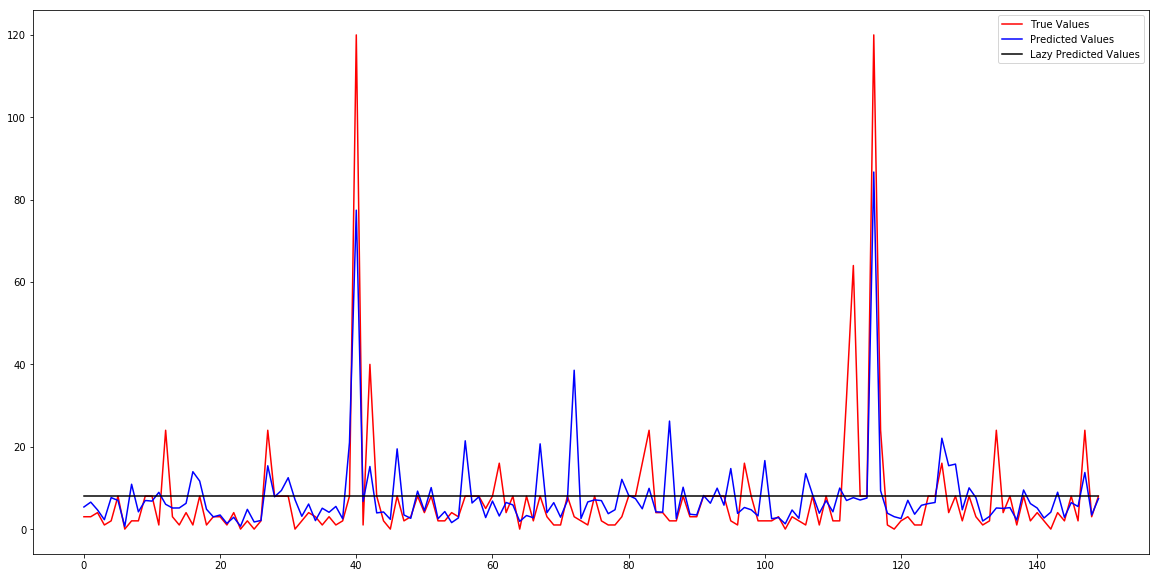

In [25]:
gridsearch_predictions = compare_predictions(x_test, y_test, clf, mean_absenteeism_time)

# Exercise part 2: 
We have now grid searched over parameters, but not seen a very significant improvement.
Your challenge now is to improve the performance of the model.

Think about...
- Trying different regression estimators
- Feature Engineering

Rules:
- NO changing the random seeds! :) 
- Every transformer you write MUST have a test!
- Must use pipelines/feature unions.